# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Aland Astudillo, Campbell Border, Disheng, Julia Yin, Koffivi

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
# Objective

- 

- 
---

# Project Design
---

# Setup

## Install Dependencies

In [1]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet
%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet
#!pip install trfl --quiet\n"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# @title Imports
import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import spaces
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

## Figure settings

In [ ]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Replace with our own literature review

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented. 


Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.


Details of the tMEG Working Memory task

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks. 

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.
I


https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
## Implementation scheme

### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [5]:
# @title Define environment
# N-back environment
class NBack(gym.Env):

    # Examples
    # N = 2
    # step_count =        [ 0  1  2  3  4  5  6 ]
    # sequence =          [ a  b  c  d  a  d  a ] (except these are usually digits between 0-9)
    # correct actions =   [ ~  ~  0  0  0  1  1 ]

    # actions =           [ ~  ~   1  0  0  1  0 ]
    # reward_class =      [ ~  ~  FP TN TN TP FN]
    # reward =            [ ~  ~  -1  0  0  1 -1]

  # Rewards input is structured as (TP, TN, FP, FN) (positive being matches)
  def __init__(self, N=2, num_trials=25, num_targets=None, rewards=(1, 1, -1, -1), obs_length=1, seed=2023):

    self.N = N
    self.num_trials = num_trials
    self.episode_length = num_trials + self.N
    self.num_targets = num_targets
    self.rewards = rewards
    self.obs_length = obs_length
    super().reset(seed=seed)

    # Check that parameters are legal
    assert(len(rewards) == 4)
    assert(num_targets is None or num_targets <= num_trials)

    # Define rewards, observation space and action space 
    self.reward_range = (min(rewards), max(rewards))  # Range of rewards based on inputs
    self.observation_space = spaces.Discrete(10)      # Single variable with 10 possibilities if using digits or 26 if using letters
    self.action_space = spaces.Discrete(2)            # 0 (No match) or 1 (Match)

  def reset(self, seed=None):

    # Seed RNG
    super().reset(seed=seed)

    # Generate sequence and correct actions
    self._generate_sequence()
    self._get_correct_actions()

    # Observation is first character
    self.step_count = 0
    observation = self._get_observation()
    

    return observation, self.step_count, None, False

  def step(self, action):

    # Calculate reward
    if self.step_count >= self.N:
      if (self.correct_actions[self.step_count - self.N]): # Match
        reward = self.rewards[0] if action else self.rewards[3] # TP if matched else FN
      else: # No match
        reward = self.rewards[2] if action else self.rewards[1] # FP if matches else TN
    else:
      reward = None

    # Return next character or None
    self.step_count += 1
    if self.step_count < self.episode_length:
      return self._get_observation(), self.step_count, reward, False
    else:
      return None, self.step_count, reward, True

  def _generate_sequence(self):

    # Generate sequence of length self.episode_length (with correct number of targets)
    while True:
      self.sequence = np.random.randint(0, 9, size=(self.episode_length))
      if not self.num_targets or sum(self._get_correct_actions()) == self.num_targets:
        break
  def _get_observation(self):

    if self.step_count < self.obs_length:
      observation = np.concatenate((np.zeros(self.obs_length - self.step_count - 1, dtype=int), self.sequence[:self.step_count + 1]))
    else:
      observation = self.sequence[self.step_count + 1 - self.obs_length : self.step_count + 1]

    return observation

  def _get_correct_actions(self):
    self.correct_actions = np.array([int(self.sequence[i] == self.sequence[i + self.N]) for i in range(self.num_trials)])
    return self.correct_actions


In [7]:
# Test environment

env = NBack(N=2, num_trials=10, obs_length=1)
obs, _, _, done = env.reset()
print(env.sequence)
print(env.step_count, obs)
while not done:
  obs, _, _, done = env.step(0)

  print(env.step_count, obs)

[6 1 8 7 4 6 0 8 8 8 1 2]
0 [6]
1 [1]
2 [8]
3 [7]
4 [4]
5 [6]
6 [0]
7 [8]
8 [8]
9 [8]
10 [1]
11 [2]
12 None


### Define a random agent

In [11]:
# Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    # Choose a random action, 0 or 1
    def choose_action(self, seq):
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        # Arrays to hold true/false positives and false negatives
        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)

        for i in range(num_episodes):
            
            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Perform action for each element in sequence
            seq, step_count, _, done = self.env.reset()
            while not done:
                action = self.choose_action(seq)
                actions[step_count] = action
                seq, step_count, _, done = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) 
            fps[i] = np.dot(actions, 1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions)

        return tps, fps, fns

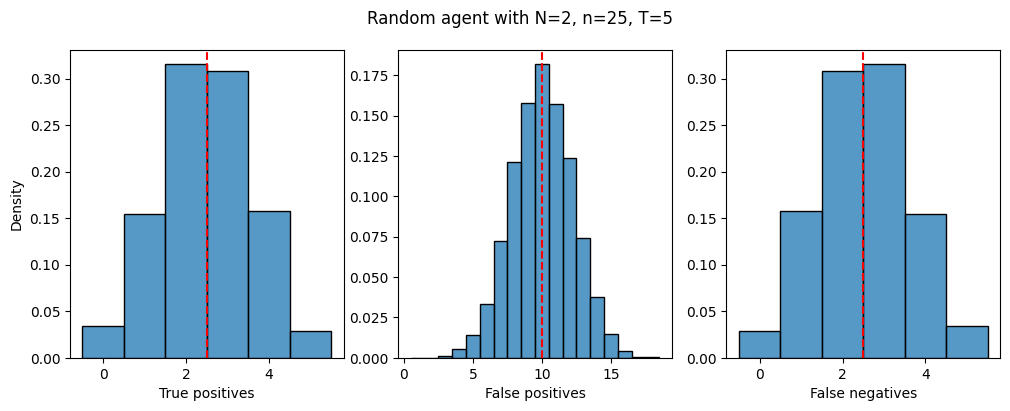

In [14]:
# @title Test random agent
# Create environment, random agent and test
N = 2
n = 25
T = 5
env = NBack(N=2, num_trials=n, num_targets=T)
agent = RandomAgent(env=env)
results = agent.test(10000)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
fig.suptitle(f"Random agent with N={N}, n={n}, T={T}")
sns.histplot(results[0], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('True positives')

plt.subplot(1, 3, 2)
sns.histplot(results[1], stat="density", bins=17, discrete=True)
plt.axvline((n-T)/2, color='r', linestyle='--')
plt.xlabel('False positives')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(results[2], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('False negatives')
plt.ylabel('')
plt.show()

### Define a simple Q-learning agent

In [ ]:
# Neural network representing the Q-function
class DQN(nn.module):
  def __init__(self, num_obs, num_actions, hidden_sizes=[], actv="ReLU()"):
    super().__init__()

    self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_sizes = hidden_sizes
    self.mlp = nn.Sequential()

    # Create net
    prev_size = self.num_obs # Initialize the temporary input feature to each layer
    for i in range(len(hidden_sizes)): # Loop over layers and create each one
        
        # Add linear layer
        current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
        layer = nn.Linear(prev_size, current_size)
        prev_size = current_size # Assign next layer input using current layer output
        self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

        # Add activation function
        actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
        self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(prev_size, self.num_actions) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    return self.mlp(x)

In [ ]:
class QLearningAgent():
    
    def __init__(self, env):
        
        self.env = env
        self.num_obs = env.memory
        self.num_actions = 2

        self.q_network = DQN()

        # Softmax layer
        softmax_layer = nn.Softmax()
        self.mlp.add_module('Output_Softmax', softmax_layer)

    def forward(self, x):

        # Do we need to reshape?
        input = torch.Tensor(x)
        return self.mlp(input)

    def choose_action(self, seq):

        # Run sequence through network
        output = self.forward(seq)
        # Choose highest likelihood action
        return np.argmax(output.detach())


    def train(self, num_episodes):

        for i in range(num_episodes):

            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Reset environment
            seq, step_count, _, done = self.env.reset()

            while not done:

                # Choose action and recieve reward
                action = self.choose_action(seq)
                actions[step_count] = action
                seq, step_count, reward, done = self.env.step(action)

                # Use reward to update network



### Define a Recurrent Deep Q-learning Agent (RDQN)

# Section 4: Model(s)

In [2]:
# Random agent
class RandomAgent(nn.Module):
    
    

SyntaxError: unexpected EOF while parsing (3220473413.py, line 4)

In [ ]:
# RNN

class LayeredRNN(nn.Module)